## Tobacco Retailers in NYC per Square-Mile per Borough

#### Author: Ryan Reyes

#### Date: August 16th, 2022

Utilizing publicly available data from the NYC government, we will use this notebook to analyze the small business industry in NYC, focusing on active Tobacco Retailer licenses. We pulled data from the following sources:

- The NYC Department of Consumer Affairs (DCA) -> this agency provides the data on licensing for small businesses in NYC. https://data.cityofnewyork.us/Business/Legally-Operating-Businesses/w7w3-xahh

- The NYC Department of Parks and Recreation (DPR) -> this agency provides data on park land sizes per borough. https://nycopendata.socrata.com/Recreation/Parks-Properties/enfh-gkve

- The New York Metropolitan Transportation Council of NYC (NYMTC) -> this agency provides land area data for each borough. https://www.nymtc.org/portals/0/pdf/CPT-HSP/NYMTC%20coord%20plan%20NYC%20CH03.pdf

- The New York Department of Consumer and Worker Protection (DCWP) -> this agency provides data on the community district caps on Tobacco Retailer licenses. https://data.cityofnewyork.us/Business/Tobacco-Retail-Dealer-and-Electronic-Cigarette-Ret/ymyu-3dbp

- Through the DCA, the DCWP also provided data confirming our count of total current active Tobacco Retailers in NYC (5,029) here: https://data.cityofnewyork.us/Business/Active-Tobacco-Retail-Dealer-Licenses/adw8-wvxb

First, we clean up some of the data, and then we organize and structure it for our analysis. From there, we isolate businesses with active licenses. Next, we determine the Top 5 most popular small business industries in NYC based on the number of active licenses in per industry. Home Improvement Contractors wind up being the number one largest small business industry in NYC, holding a 29% market share of all small businesses. At 11%, Tobacco Retailers hold the second largest market share of small business industries in NYC. From here, we adjust the borough land areas to remove the public park land areas since it can muddle our results. Lastly, we visualize our results with a Seaborn Scatter Plot. At the bottom, we highlight the current caps on Tobacco Retailer licenes per borough.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt

In [2]:
# this dataset comes from NYC's open gov datasets collections, and it provides the acreage of park land per borough.

city_parks = pd.read_csv("Parks_Properties.csv")

In [34]:
# loading the data into the notebook.
# this dataset comes from NYC's open gov datasets collections.
# this dataset entails small business owners with licenses to operate a business in NYC.

'''
Note: we must specify the data types for two columns, 'BIN' and 'BBL', which have mixed data types.
Leaving the mixed data types can cause memory usage issues when loading in the csv file.
'''

legal_biz = pd.read_csv("Legally_Operating_Businesses.csv", dtype={'BIN': str, 'BBL': str})

In [4]:
legal_biz = legal_biz.rename(columns={'Address Borough': 'Borough'})

In [5]:
legal_biz['Industry'] = legal_biz['Industry'].str.upper()

In [6]:
legal_biz['Borough']  = legal_biz['Borough'].str.upper()

In [7]:
# filtering the dataset to remove all businesses with inactive licenses.

active_biz = legal_biz[legal_biz['License Status'] == 'Active']

In [8]:
'''
Note: when we view the normalized data, we see that there are two industries that we should
probably combine because they are so similar that it wouldn't make sense to count them
separately. The two industries are "Ticket Seller" and "Ticket Seller Business."

'''

biz_normalized = active_biz['Industry'].value_counts(normalize=True).multiply(100)

In [9]:
# Combining the 'Ticket Seller' and 'Ticket Seller Business' into one, using the 'Ticket Seller' industry name.

biz_normalized['TICKET SELLER'] = biz_normalized['TICKET SELLER'] + biz_normalized['TICKET SELLER BUSINESS']

In [10]:
# Dropping the 'Ticket Seller Business' industry since it is now redundant and no longer needed.

biz_normalized_cleaned = biz_normalized.drop('TICKET SELLER BUSINESS')

In [11]:
# Sorting the businesses by counting which are the most dense (concentrated) industries, and then turning this into a dataframe.
# Note: we reset the index to turn the industry index back into a column, so that we have better control over the data.
# We round to 3 decimal points here because some industries are so small, that they appear as zero when only viewing out to 2 decimal points.

biz_by_type = pd.DataFrame(round(biz_normalized_cleaned, 3)).reset_index().rename(columns={'index': 'Industry', 'Industry': 'Market Share'})

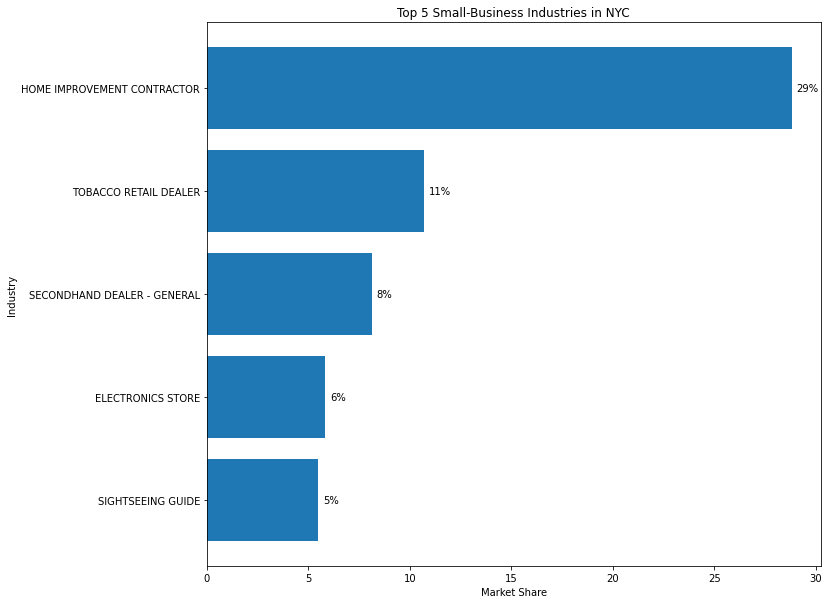

In [63]:
# Plotting the top 5 industries with the most businesses, counting only those with active licenses.

fig = plt.figure(figsize = (11, 10))
 
bars = plt.barh(biz_by_type['Industry'].head(), biz_by_type['Market Share'].head())

#We use this line below to invert the graph, so that it displays from largest to smallest (descending order)
plt.gca().invert_yaxis()


'''
For placing a label on top of each bar of a horizontal bar graph, we adopted the following code
from this StackOverFlow page: https://stackoverflow.com/questions/28931224/how-to-add-value-labels-on-a-bar-chart,
which covers our needs so well, that there's no reason to re-invent the wheel. We simply need to make some
modifications to the code to change the number format, to add a percent symbol, and to rename some parts of the
code. Other than that, the code block is very well structured, so we won't change anything else.

'''

# For each bar: Place a label
for bar in bars:
# Get x and y placement of label from rect.
    x_value = bar.get_width()
    y_value = bar.get_y() + (bar.get_height() / 2)

# Number of points between bar and label. Change to your liking.
    space = 5
# Vertical alignment for positive values
    ha = 'left'

# If value of bar is negative: Place label left of bar
    if x_value < 0:
        # Note: this inversion line of code is not needed for our plot, but we'll leave it for simplicity's sake.
        # Invert space to place label to the left
        space *= -1
        # Horizontally align label at right
        ha = 'right'

# Use X value as label and format number with zero decimal places
    label = "{:.0f}".format(x_value)

# Create annotation
    plt.annotate(
        (label+'%'),                # Use 'label' as label, and add the percent symbol to each
        (x_value, y_value),         # Place label at end of the bar
        xytext=(space, 0),          # Horizontally shift label by 'space'
        textcoords="offset points", # Interpret 'xytext' as offset in points
        va='center',                # Vertically center label
        ha=ha)                      # Horizontally align label differently for positive and negative values.


plt.title('Top 5 Small-Business Industries in NYC')
plt.ylabel('Industry')
plt.xlabel('Market Share')
plt.show()

In [13]:
# Isolating the tobacco retailers.

active_tobacco_biz = active_biz[active_biz['Industry'] == 'TOBACCO RETAIL DEALER']

In [14]:
# The percentages of tobacco retailers by borough.

tobacco_sellers_where = round(active_tobacco_biz['Borough'].value_counts(normalize=True).multiply(100), 2)

In [15]:
# Tobacco retailers with full coordinates (longitude and latitude).

tobacco_with_coordinates = active_tobacco_biz[((active_tobacco_biz['Longitude'].isnull() == False) & (active_tobacco_biz['Latitude'].isnull() == False))]

In [16]:
# Tobacco retailers with either no coordinates, or incomplete coordinates.

tobacco_without_coordinates = active_tobacco_biz[((active_tobacco_biz['Longitude'].isnull() == True) & (active_tobacco_biz['Latitude'].isnull() == True))]

In [17]:
'''
There are only 12 tobacco retailers without coordinates, compared to 5017 tobacco retailers with coordinates,
which means only 0.24% of all tobacco retailers in this dataset are missing coordinates. This means that our
location data for tobacco retailers has an accuracy of our around 99.76% when calculated as: 0.24 percent equals
0.0024 in decimal form (0.24/100 = 0.0024), and with 1.00 representing 100% in decimal form, to find our difference,
we subtract 0.0024 from 1.00, which is 1.00 - 0.0024, which equals 0.9976, which when multiplied by 100 to get it
back into percentage form, 0.9976*100, equals 99.76%.

'''

percentage_tobacco_without_coordinates = round((tobacco_without_coordinates.shape[0]/tobacco_with_coordinates.shape[0])*100, 2)

In [18]:
# Here, we are checking to see which boroughs our tobacco retailers without coordinates reside in.

tobacco_without_coordinates['Borough'].value_counts()

QUEENS      10
BROOKLYN     1
BRONX        1
Name: Borough, dtype: int64

In [19]:
# Here, we are getting the number of tobacco retailers in each borough, and saving each as a separate variable.

m_stores = tobacco_with_coordinates[tobacco_with_coordinates['Borough'] == 'MANHATTAN'].shape[0]
q_stores = tobacco_with_coordinates[tobacco_with_coordinates['Borough'] == 'QUEENS'].shape[0]
bk_stores = tobacco_with_coordinates[tobacco_with_coordinates['Borough'] == 'BROOKLYN'].shape[0]
bx_stores = tobacco_with_coordinates[tobacco_with_coordinates['Borough'] == 'BRONX'].shape[0]
si_stores = tobacco_with_coordinates[tobacco_with_coordinates['Borough'] == 'STATEN ISLAND'].shape[0]

In [20]:
borough_area = {
    'Land Area (sq-mi)': [23, 109, 71, 42, 59],
    'Retailers per Borough': [m_stores, q_stores, bk_stores, bx_stores, si_stores],
}


retailer_density = pd.DataFrame(data = borough_area, index=['MANHATTAN', 'QUEENS', 'BROOKLYN', 'BRONX', 'STATEN ISLAND'])

retailer_density['Density (retailers per sq-mi)'] = retailer_density['Retailers per Borough'] / retailer_density['Land Area (sq-mi)']

'''
Here, we have to reset the index twice. Once to rename the index to BOROUGH. The second time is to reset the index
number order to start from 0 and to ascend from there, so for the second reset, we also drop the initial numbered
index that we created with the first reset.

'''

retailer_density = retailer_density.reset_index().rename(columns={'index': 'BOROUGH'}).sort_values(by=['BOROUGH']).reset_index(drop=True)

In [21]:
retailer_density

,BOROUGH,Land Area (sq-mi),Retailers per Borough,Density (retailers per sq-mi)
0,BRONX,42,843,20.071429
1,BROOKLYN,71,1374,19.352113
2,MANHATTAN,23,1277,55.521739
3,QUEENS,109,1269,11.642202
4,STATEN ISLAND,59,254,4.305085


In [22]:
# Here, we are changing the borough initials to their full names in-order to match the legal_biz dataset for clarity.

parks_boroughs_dict = {
    'M': 'MANHATTAN',
    'Q': 'QUEENS',
    'B': 'BROOKLYN',
    'X': 'BRONX',
    'R': 'STATEN ISLAND'
}

city_parks['BOROUGH'] = city_parks['BOROUGH'].map(parks_boroughs_dict)

In [23]:
# Here, we are summing the acres of parks per borough.

parks_acres_borough = city_parks.groupby('BOROUGH')['ACRES'].sum()

In [24]:
# Here, we are converting acres to square-miles and turning the info into a dataframe; 1 acre = 0.0015625 square-miles.

parks_acres_borough_miles = pd.DataFrame(round((parks_acres_borough*0.0015625), 2)).reset_index().rename(columns={'ACRES': 'Land Area (sq-mi)'}).sort_values(by=['BOROUGH'])

In [25]:
'''
Here, we update our Land Area calculation to remove all land area that
is wide open and devoid of both tobacco retailers and housing, which
is basically all public park land. This gives us a more accurate density
calculation because if we keep the public park land as part of each
borough's total land area, then we are corrupting our data because the
public park land has nothing to do with tobacco retailers, and is mostly
wide open space that is legally protected from businesses such as tobacco
retailers.

'''

retailer_density['Land Area (sq-mi)'] = retailer_density['Land Area (sq-mi)'] - parks_acres_borough_miles['Land Area (sq-mi)']

In [26]:
# Here, we are re-calculating our Density column to reflect the changes in our Land Area column.

retailer_density['Density (retailers per sq-mi)'] = round((retailer_density['Retailers per Borough']/retailer_density['Land Area (sq-mi)']), 2)

In [27]:
# Here, we are sorting our retail_density dataframe by Density from most dense to least dense.

retail_density = retailer_density.sort_values(by=['Density (retailers per sq-mi)'], ascending=False).reset_index(drop=True)

In [28]:
# Here, we are isolating the density value of each borough, and saving each as their own variable.

bx_density = retail_density[retail_density['BOROUGH'] == 'BRONX']['Density (retailers per sq-mi)'].reset_index(drop=True)[0]
bk_density = retail_density[retail_density['BOROUGH'] == 'BROOKLYN']['Density (retailers per sq-mi)'].reset_index(drop=True)[0]
m_density = retail_density[retail_density['BOROUGH'] == 'MANHATTAN']['Density (retailers per sq-mi)'].reset_index(drop=True)[0]
q_density = retail_density[retail_density['BOROUGH'] == 'QUEENS']['Density (retailers per sq-mi)'].reset_index(drop=True)[0]
si_density = retail_density[retail_density['BOROUGH'] == 'STATEN ISLAND']['Density (retailers per sq-mi)'].reset_index(drop=True)[0]

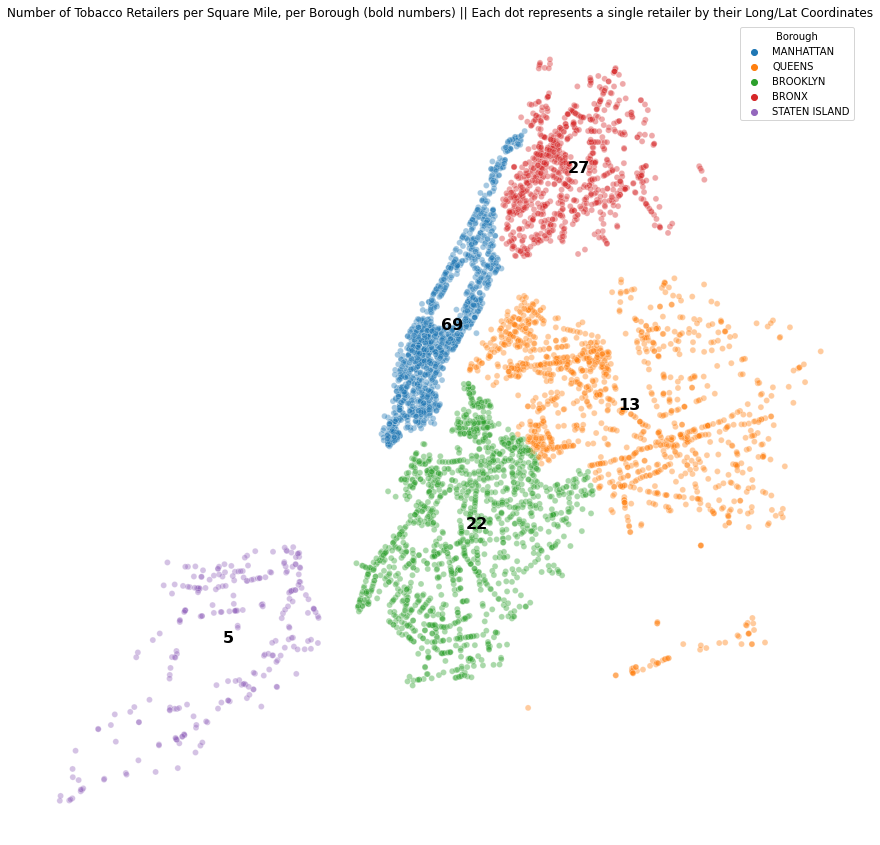

In [29]:
'''
Note1: Seaborn doesn't know what longitude and latitude is. Thus, even though longitude is vertical,
and latitude is horizontal, if we were to plot them as such, with x being latitude, and y being longitude,
we would get a plot with an inverted map because Seaborn is just plotting the values as cartesian coordinates.
Thus, in-order to get a properly displayed map with our coordinates, we must swap the coordinate planes, with
x being longitude, and y being latitude, which results in the same exact plotted map, but with proper orientation.

Note2: I chose to use Seaborn instead of plain Matplotlib because it's very difficult to create a proper legend
for this type of plot while using Matplotlib by itself.

'''

fig = plt.figure(figsize = (15, 15))

sns.scatterplot(x=tobacco_with_coordinates['Longitude'], y=tobacco_with_coordinates['Latitude'], hue=tobacco_with_coordinates['Borough'], alpha=0.4).set(title='Number of Tobacco Retailers per Square Mile, per Borough (bold numbers) || Each dot represents a single retailer by their Long/Lat Coordinates')

# Here, we are annotating each borough to show their density calculations. We use the mean of each of their coordinates so that we can place the density number in the center of each borough.

plt.text(tobacco_with_coordinates[tobacco_with_coordinates['Borough'] == 'BRONX'][['Longitude', 'Latitude']].mean()[0], tobacco_with_coordinates[tobacco_with_coordinates['Borough'] == 'BRONX'][['Longitude', 'Latitude']].mean()[1], round(bx_density), fontsize=16, weight='bold')
plt.text(tobacco_with_coordinates[tobacco_with_coordinates['Borough'] == 'BROOKLYN'][['Longitude', 'Latitude']].mean()[0], tobacco_with_coordinates[tobacco_with_coordinates['Borough'] == 'BROOKLYN'][['Longitude', 'Latitude']].mean()[1], round(bk_density), fontsize=16, weight='bold')
plt.text(tobacco_with_coordinates[tobacco_with_coordinates['Borough'] == 'MANHATTAN'][['Longitude', 'Latitude']].mean()[0], tobacco_with_coordinates[tobacco_with_coordinates['Borough'] == 'MANHATTAN'][['Longitude', 'Latitude']].mean()[1], round(m_density), fontsize=16, weight='bold')
plt.text(tobacco_with_coordinates[tobacco_with_coordinates['Borough'] == 'QUEENS'][['Longitude', 'Latitude']].mean()[0], tobacco_with_coordinates[tobacco_with_coordinates['Borough'] == 'QUEENS'][['Longitude', 'Latitude']].mean()[1], round(q_density), fontsize=16, weight='bold')
plt.text(tobacco_with_coordinates[tobacco_with_coordinates['Borough'] == 'STATEN ISLAND'][['Longitude', 'Latitude']].mean()[0], tobacco_with_coordinates[tobacco_with_coordinates['Borough'] == 'STATEN ISLAND'][['Longitude', 'Latitude']].mean()[1], round(si_density), fontsize=16, weight='bold')

# Here, we are disabling both the x and y axis, in-order to simplify our visualiztion.

plt.axis('off')

# Here, we are simply showing the plot that we just created above.

plt.show()

In [67]:
tobacco_caps = pd.read_csv('Tobacco_Retail_Dealer_and_Electronic_Cigarette_Retail_Dealer_Caps_by_Community_District__2019_.csv')

In [74]:
tobac_caps_borough = tobacco_caps.groupby('Borough')[['Tobacco Retail Dealer Cap', 'Electronic Cigarette Retail Dealer Cap']].sum().reset_index()

In [76]:
tobac_caps_borough['Total Caps'] = tobac_caps_borough['Tobacco Retail Dealer Cap'] + tobac_caps_borough['Electronic Cigarette Retail Dealer Cap']

In [82]:
total_tobac_caps = tobac_caps_borough.sort_values(by=['Total Caps'], ascending=False).reset_index(drop=True)

In [99]:
total_cap_num = tobac_caps_borough['Total Caps'].sum()

In [100]:
total_active_tobacco_licenses = tobacco_caps.groupby('Borough')['Active Tobacco Retail Dealer Licenses'].sum().sum()

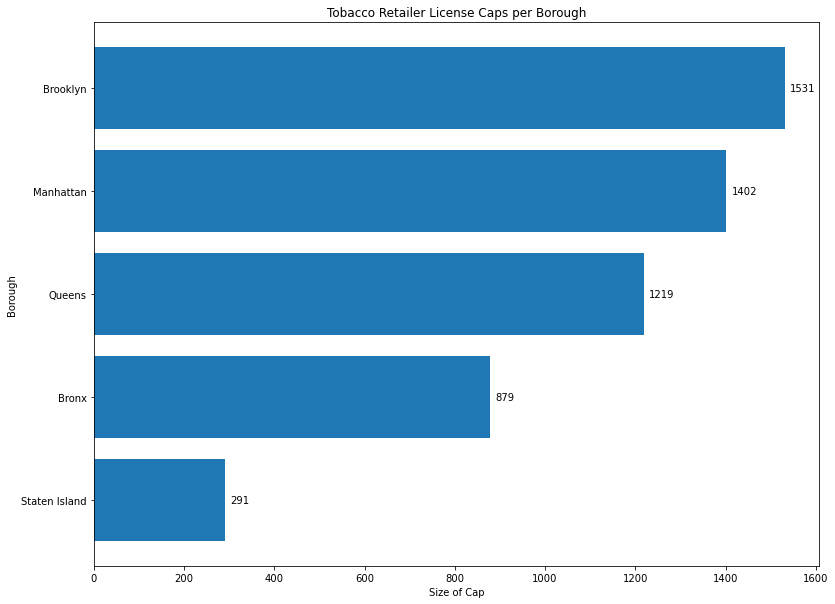

In [87]:
# Plotting the current Tobacco Retailer License caps per borough.

fig = plt.figure(figsize = (13, 10))
 
bars1 = plt.barh(total_tobac_caps['Borough'], total_tobac_caps['Total Caps'])

#We use this line below to invert the graph, so that it displays from largest to smallest (descending order)
plt.gca().invert_yaxis()

# For each bar: Place a label
for barr in bars1:
# Get x and y placement of label from rect.
    x_value = barr.get_width()
    y_value = barr.get_y() + (barr.get_height() / 2)

# Number of points between bar and label. Change to your liking.
    space = 5
# Vertical alignment for positive values
    ha = 'left'

# If value of bar is negative: Place label left of bar
    if x_value < 0:
        # Note: this inversion line of code is not needed for our plot, but we'll leave it for simplicity's sake.
        # Invert space to place label to the left
        space *= -1
        # Horizontally align label at right
        ha = 'right'

# Use X value as label and format number with zero decimal places
    label = "{:.0f}".format(x_value)

# Create annotation
    plt.annotate(
        (label),                    # Use 'label' as label
        (x_value, y_value),         # Place label at end of the bar
        xytext=(space, 0),          # Horizontally shift label by 'space'
        textcoords="offset points", # Interpret 'xytext' as offset in points
        va='center',                # Vertically center label
        ha=ha)                      # Horizontally align label differently for positive and negative values.


plt.title('Tobacco Retailer License Caps per Borough')
plt.ylabel('Borough')
plt.xlabel('Size of Cap')
plt.show()